<a href="https://colab.research.google.com/github/Ajay-2007/deep-learning-projects/blob/master/5.applying_cnn_to_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [48]:
!pwd

/content


In [0]:
mean_gray = 0.1307
stddev_gray = 0.3081

# formula for data normalization
# input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((mean_gray,),(stddev_gray,))])


train_dataset = datasets.MNIST(root='./content',
                               train=True,
                               transform=transforms,
                               download=True)

test_dataset = datasets.MNIST(root='./content',
                              train=False,
                              transform=transforms,
                              download=False)

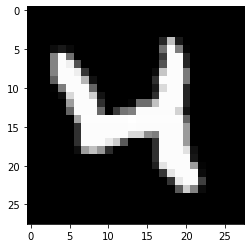

In [50]:
import matplotlib.pyplot as plt

random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray

plt.imshow(random_img.reshape(28,28), cmap='gray')

In [51]:
# label
print(train_dataset[20][1])

4


In [0]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size = batch_size,
                                    shuffle = True)

test_load = torch.utils.data.DataLoader(dataset=test_dataset,
                                   batch_size=batch_size,
                                   shuffle=False)  

In [53]:
len(train_dataset), len(train_load)

(60000, 600)

In [54]:
len(test_dataset), len(test_load)

(10000, 100)

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Same padding --> input_size = output_size
    # Same Padding = (filter_size - 1) / 2 --> (3 - 1) / 2
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    # The output size of each of the 8 feature maps:
    # [(input_size - filter_size + 2(padding))/stride + 1] = 28 - 3 + 2(1)/1 + 1 --> 25+2+1 --> 28
    self.batchnorm1 = nn.BatchNorm2d(8)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size = 2)
    # The output_size = 28/2 --> 14
    # same padding --> (5-1)/2 = 2
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    # Output size of each of the 32 feature maps [(14 - 5 + 2*2 + 1)] --> 9+5 --> 14
    self.batchnorm2 = nn.BatchNorm2d(32)
    # Flatten the 32 feature maps: 7*7*32 -> 1568
    self.fc1 = nn.Linear(1568, 600)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(600, 10)

  def forward(self, x):
    out = self.cnn1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.cnn2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool(out)
    # Flatten the 32 feature map from Max Pool to feed it to the first fully connected layer
    # (100, 1568)
    out = out.view(-1, 1568)
    # Then we forward through our fully connected layer
    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)
    return out

In [56]:
torch.cuda.is_available()

True

In [0]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [58]:
iteration = 0
correct = 0

for i, (inputs, labels) in enumerate(train_load):
  if CUDA:
    inputs = inputs.cuda()
    labels = labels.cuda()

  print('For on iteration, this is what happens: ')
  # Each tensor propagated through the network should be 4D (batch_size, channels, rows, cols)
  print('Input Shape: ', inputs.shape)
  print('Labels Shape: ', labels.shape)
  output = model.forward(inputs)
  _, predicted = torch.max(output, 1)
  print('Pridicted Shape: ', predicted.shape)
  print('Predicted Tensor: ')
  print(predicted)
  if CUDA:
    correct += (predicted.cpu() == labels.cpu()).sum()
  else:
    correct += (predicted == labels).sum()
  break

For on iteration, this is what happens: 
Input Shape:  torch.Size([100, 1, 28, 28])
Labels Shape:  torch.Size([100])
Pridicted Shape:  torch.Size([100])
Predicted Tensor: 
tensor([4, 3, 5, 1, 3, 5, 1, 7, 4, 7, 1, 5, 7, 5, 7, 0, 3, 3, 7, 7, 7, 4, 4, 4,
        5, 7, 7, 1, 3, 4, 5, 5, 4, 7, 7, 5, 7, 7, 7, 4, 9, 4, 3, 5, 7, 5, 4, 7,
        5, 5, 3, 4, 5, 3, 5, 7, 5, 5, 1, 7, 4, 7, 7, 7, 9, 7, 5, 5, 7, 7, 7, 1,
        4, 7, 3, 3, 5, 3, 3, 2, 4, 4, 0, 3, 7, 5, 7, 4, 3, 3, 1, 3, 7, 5, 7, 7,
        4, 8, 4, 7], device='cuda:0')


In [61]:
# Training the CNN
num_epochs = 10
train_loss = [] 
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
  correct = 0
  iterations = 0
  iter_loss = 0.0

  model.train()

  for i, (inputs, labels) in enumerate(train_load):
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    output = model.forward(inputs)
    loss = loss_fn(output, labels)
    iter_loss += loss.item()

    optimizer.zero_grad() # w <-- w - lr*gradient
    loss.backward()
    # update the weight
    optimizer.step()

    _, predicted = torch.max(output, 1)
    if CUDA:
      correct += (predicted.cpu() == labels.cpu()).sum().item()
    else:
      correct += (predicted == labels).sum().item()
    
    iterations += 1
  train_loss.append(iter_loss / iterations)

  train_accuracy.append(100 * (correct / len(train_dataset)))

  # Testing Phase
  testing_loss = 0.0
  correct = 0
  iterations = 0

  model.eval()
  for i, (inputs, labels) in enumerate(test_load):
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    output = model.forward(inputs)
    loss = loss_fn(output, labels)
    testing_loss += loss.item()
    _, predicted = torch.max(output, 1)
    if CUDA:
      correct += (predicted.cpu() == labels.cpu()).sum().item()
    else:
      correct += (predicted == labels).sum().item()
    
    iterations += 1
  test_loss.append(testing_loss / iterations)
  
  test_accuracy.append(100 * (correct / len(test_dataset)))

  print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}'\
        .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

Epoch 1/10, Training Loss: 0.083, Training Accuracy: 97.565, Testing Loss: 0.047, Testing Accuracy: 98.380
Epoch 2/10, Training Loss: 0.072, Training Accuracy: 97.885, Testing Loss: 0.037, Testing Accuracy: 98.820
Epoch 3/10, Training Loss: 0.064, Training Accuracy: 98.180, Testing Loss: 0.054, Testing Accuracy: 98.420
Epoch 4/10, Training Loss: 0.055, Training Accuracy: 98.420, Testing Loss: 0.035, Testing Accuracy: 98.880
Epoch 5/10, Training Loss: 0.056, Training Accuracy: 98.418, Testing Loss: 0.037, Testing Accuracy: 98.830
Epoch 6/10, Training Loss: 0.053, Training Accuracy: 98.507, Testing Loss: 0.036, Testing Accuracy: 98.950
Epoch 7/10, Training Loss: 0.050, Training Accuracy: 98.548, Testing Loss: 0.040, Testing Accuracy: 98.930
Epoch 8/10, Training Loss: 0.049, Training Accuracy: 98.625, Testing Loss: 0.033, Testing Accuracy: 99.070
Epoch 9/10, Training Loss: 0.045, Training Accuracy: 98.710, Testing Loss: 0.038, Testing Accuracy: 99.060
Epoch 10/10, Training Loss: 0.046, Tr

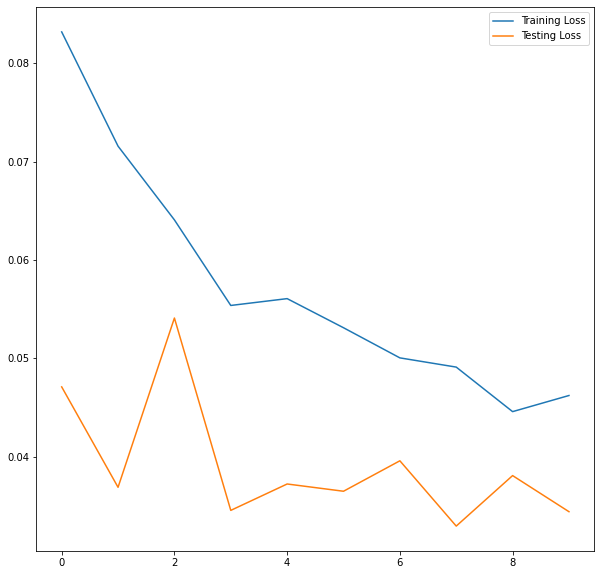

In [62]:
# Plotting the Loss
f = plt.figure(figsize = (10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

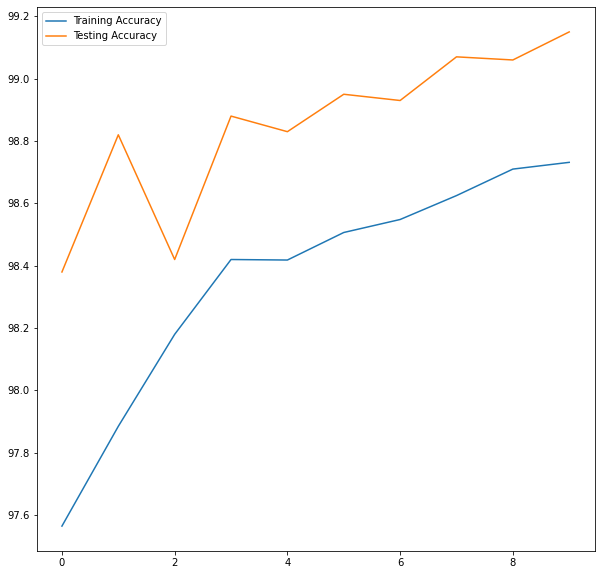

In [64]:
# Plotting the Accuracy
f = plt.figure(figsize = (10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [69]:
img = test_dataset[6][0].resize_((1, 1, 28, 28))
labels = test_dataset[6][1]

model.eval() 
if CUDA:
  model = model.cuda()
  img = img.cuda()

output = model(img)
_, predicted = torch.max(output, 1)
print('Prediction is : {}'.format(predicted.item()))
print('Actual is: {}'.format(labels))



Prediction is : 4
Actual is: 4
